In [2]:
#1
# Step-1: Importing dependencies
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
import nltk
import re

# Step-2: Loading the dataset
# Load the dataset from a CSV file named 'dataset.csv'
df = pd.read_csv('fifa_world_cup_2022_tweets.csv')

# Step-3: Text Preprocessing
# Define a function for text preprocessing
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text=text.split()
    if 'http' in text:
      text.pop(text.index('http'))
    if 'https' in text:
      text.pop(text.index('https'))
    text = ' '.join(text)
    # Convert to lowercase
    text = text.lower()
    return text

# Apply text preprocessing to the 'Tweet' column and store the result in 'Cleaned_Tweet'
df['Cleaned_Tweet'] = df['Tweet'].apply(preprocess_text)

# Step-4: Splitting the dataset into training and testing sets


In [3]:
df = df.dropna()

X = df['Cleaned_Tweet']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(y_test))
# Step-5: Feature Extraction using TF-IDF
# Initialize a TF-IDF vectorizer with a maximum of 5000 features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Step-6: Train and evaluate different models with hyperparameter tuning
models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

best_model = None
best_accuracy = 0

# Loop through the models, fit them, and evaluate their performance
for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model_name
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))
    print("\n")

# Print the best model and its accuracy
print(f"Best Model: {best_model} (Accuracy: {best_accuracy:.2f})")

# Step-7: Using LSTM for text classification
max_words = 5000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_sequence_length = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

embedding_dim = 100

# Step-8: Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(100))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step-9: Train the LSTM model
model.fit(X_train_padded, pd.get_dummies(y_train), epochs=5, batch_size=64, validation_split=0.2)



4505
Model: Naive Bayes
Accuracy: 0.69
              precision    recall  f1-score   support

    negative       0.70      0.73      0.71      1149
     neutral       0.66      0.61      0.63      1648
    positive       0.72      0.75      0.74      1708

    accuracy                           0.69      4505
   macro avg       0.69      0.70      0.69      4505
weighted avg       0.69      0.69      0.69      4505



Model: SVM
Accuracy: 0.73
              precision    recall  f1-score   support

    negative       0.75      0.71      0.73      1149
     neutral       0.67      0.71      0.69      1648
    positive       0.78      0.75      0.76      1708

    accuracy                           0.73      4505
   macro avg       0.73      0.73      0.73      4505
weighted avg       0.73      0.73      0.73      4505



Model: Random Forest
Accuracy: 0.68
              precision    recall  f1-score   support

    negative       0.68      0.67      0.67      1149
     neutral       0.65 

In [4]:
# Step-10: Make predictions using the LSTM model and evaluate its performance
'''y_pred_lstm = model.predict_classes(X_test_padded)
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
print(f"LSTM Model Accuracy: {accuracy_lstm:.2f}")
print(classification_report(y_test, y_pred_lstm))'''
# Convert labels in y_test to integers if they are in string format
# if isinstance(y_test.iloc[0], str):
#     y_test = y_test.map({'label1': 0, 'label2': 1, 'label3': 2})  # Replace
# Make predictions using the LSTM model

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)


y_probabilities = model.predict(X_test_padded)
'''
# Convert probabilities to class labels by selecting the class with the highest probability
y_pred_lstm = [np.argmax(prob) for prob in y_probabilities]

# Calculate accuracy
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)

print(f"LSTM Model Accuracy: {accuracy_lstm:.2f}")
print(classification_report(y_test, y_pred_lstm))'''
#this is my code please modify it to get the op with final accuracy

141/141 [==============================] - 3s 19ms/step


'\n# Convert probabilities to class labels by selecting the class with the highest probability\ny_pred_lstm = [np.argmax(prob) for prob in y_probabilities]\n\n# Calculate accuracy\naccuracy_lstm = accuracy_score(y_test, y_pred_lstm)\n\nprint(f"LSTM Model Accuracy: {accuracy_lstm:.2f}")\nprint(classification_report(y_test, y_pred_lstm))'

In [5]:
# Ensure that y_test has the same length as X_test_padded
print(len(y_test), len(X_test_padded))
assert len(y_test) == len(X_test_padded), "Length mismatch between y_test and X_test_padded"

# Make predictions using the LSTM model
y_probabilities = model.predict(X_test_padded)

# Convert probabilities to class labels by selecting the class with the highest probability
y_pred_lstm = [np.argmax(prob) for prob in y_probabilities]


4505 4505
141/141 [==============================] - 3s 18ms/step


In [6]:


accuracy_lstm = accuracy_score(y_test, y_pred_lstm)

print(f"LSTM Model Accuracy: {accuracy_lstm:.2f}")
print(classification_report(y_test, y_pred_lstm))
print(f"Length of X_test_padded: {len(X_test_padded)}")
print(f"Length of y_test: {len(y_test)}")
print(f"Shape of X_test_padded: {X_test_padded.shape}")

LSTM Model Accuracy: 0.71
              precision    recall  f1-score   support

           0       0.70      0.74      0.72      1149
           1       0.68      0.66      0.67      1648
           2       0.76      0.75      0.75      1708

    accuracy                           0.71      4505
   macro avg       0.71      0.72      0.71      4505
weighted avg       0.71      0.71      0.71      4505

Length of X_test_padded: 4505
Length of y_test: 4505
Shape of X_test_padded: (4505, 60)


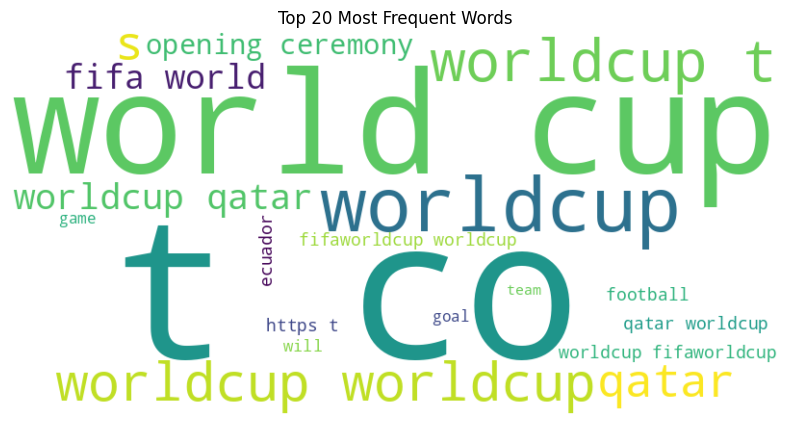

In [7]:
#Creating a wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Combine all the cleaned text data into a single string
all_text = ' '.join(df['Cleaned_Tweet'])

# Create a WordCloud object and generate the word cloud
wordcloud = WordCloud(width=800, height=400, max_words=20, background_color='white').generate(all_text)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 20 Most Frequent Words')
plt.show()
